<a href="https://colab.research.google.com/github/JoshJingtianWang/TCGA-Splicing-Data-Cleaning-and-Filtering/blob/main/CleanRatschData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Counts of normal vs cancer data in TCGA

# Getting PSI table of just normal samples

In [ ]:
#Bash
#look at first few columns of the raw table
#https://stackoverflow.com/questions/538664/using-sed-how-do-you-print-the-first-n-characters-of-a-line
head -n 2 merge_graphs_alt_3prime_C2.confirmed.txt | cut -c 1-100

In [ ]:
#Python
#get number of normal samples and number of cancer samples
import pandas as pd
import re
import os
os.getcwd() #get current working directory
psi=pd.read_csv('test',sep='\t')
my_list=list(psi) #turn header into a list
my_list.sort()
del my_list[-6:] #remove elements not TCGA barcodes

trimmed_list=[]
normcount=0
cancount=0
for item in my_list:   
     s0=re.sub(r'^TCGA-\w\w-\w\w\w\w-|[A-Z]-\d\d[A-Z]-\w{4}-\d{2}\..+$', '', item)
     s1=int(s0.lstrip('0'))   #remove leading zero in barcode
     if s1 < 10:
         cancount=cancount+1
     else:
         normcount=normcount+1
     trimmed_list.append(s1)


In [67]: normcount
Out[67]: 709

In [68]: cancount
Out[68]: 9310


In [ ]:
#get number of patients with matching normal&cancer samples
In [14]: normlist=[]
    ...: canlist=[]
    ...: for item in my_list:   
    ...:      samplecode=re.sub(r'^TCGA-|-\d\d[A-Z]-\d\d[A-Z]-\w{4}-\d{2}\..+$', '', item)
    ...:      typecode=re.sub(r'^TCGA-\w\w-\w\w\w\w-|[A-Z]-\d\d[A-Z]-\w{4}-\d{2}\..+$', '', item)
    ...:      typecode=int(typecode.lstrip('0'))   #remove leading zero in barcode
    ...:      if typecode < 10:
    ...:          canlist.append(samplecode)
    ...:      else:
    ...:          normlist.append(samplecode)


In [15]: len(set(canlist))
Out[15]: 9163

In [16]: len(set(normlist))
Out[16]: 709


In [ ]:
interset=set(normlist) & set(canset)
interlist=list(interset)

In [24]: len(interlist)
Out[24]: 659

Use list of normal samples to get table of PSI values of all normal samples

In [ ]:
#python
normlist=[]

for item in my_list:   #number of patients with matching normal&cancer samples
    samplecode=re.sub(r'^TCGA-|-\d\d[A-Z]-\d\d[A-Z]-\w{4}-\d{2}\..+$', '', item)
    typecode=re.sub(r'^TCGA-\w\w-\w\w\w\w-|[A-Z]-\d\d[A-Z]-\w{4}-\d{2}\..+$', '', item)
    typecode=int(typecode.lstrip('0'))   #remove leading zero in barcode
    if typecode >= 10 and typecode <20:
      normlist.append(item)

mystr=','.join(normlist)

In [ ]:
#Bash

#using the csvtools to extract just the normal columns from the giant table
VAR= #list of normal sample IDs delimited by comma
csvcut -t -c $VAR myfile #-t input is tab delimited #-c extract the columns in $VAR

# Getting mean and quartile of each row

Splicing analysis plan:
For normal sample PSIs, only keep rows with at least 20 (?) non-'nan' datapoints. 'nan's should not be replaced with zero. After trimming rows. Get mean of each row.
Match samples with SF3B1 K700E mutations with normal table first. 
PSI value of at least 10 times the inter-quartile range above/below the upper/lower quartile and marked them as outliers

In [ ]:
#Bash
#request interactive session
srun -A jingtiw2 -c 4 --pty /bin/bash -i #-c flag specifies number of cores

In [ ]:
module load python
#In python
ipython

#read normal table into pandas in chunks and concatenate
import pandas as pd
import datetime as dt
#https://plotly.com/python/v3/ipython-notebooks/big-data-analytics-with-pandas-and-sqlite/
#https://stackoverflow.com/questions/11622652/large-persistent-dataframe-in-pandas/12193309#12193309
start = dt.datetime.now()
chunksize = 20000
print('{} seconds: Starting...'.format((dt.datetime.now() - start).seconds))
tp = pd.read_csv('normaltablewID.txt', chunksize=chunksize, iterator=True, encoding='utf-8', sep='\t')
normdf=pd.concat(list(tp), ignore_index=True)
print('{} seconds: completed'.format((dt.datetime.now() - start).seconds)) #takes about 17 seconds to complete on interactive node (4 cores)

#basic dataframe info
#https://github.com/ine-rmotr-curriculum/freecodecamp-intro-to-pandas/blob/master/3%20-%20Pandas%20-%20DataFrames.ipynb
normdf.head
normdf.shape

#keep rows with at least 20 non-'nan' datapoints
#https://stackoverflow.com/questions/23203638/filter-out-rows-with-more-than-certain-number-of-nan
normdf_nafiltered=normdf.dropna(thresh=20) #filtering out rows with more than 20 NaNs
normdf_nafiltered.head
normdf_nafiltered.shape

#get mean of each row
#https://www.delftstack.com/api/python-pandas/pandas-dataframe-dataframe.mean-function/
normdf_nafiltered['average'] = normdf_nafiltered.mean(numeric_only=True, axis=1,skipna=True) #mean as a new column

#compare each tumor with mean of normal

#value of at least 10 times the inter-quartile range above/below the upper/lower quartile and marked them as outliers

# Find cancer samples with the SF3B1 K700E mutation

In [ ]:
#So, turns out the UUIDs in the Ratsch files are aliquot IDs, all UUIDs queried from TCGA in 2019 are ssmIDs and case IDs.
#Need to convert the case UUIDs from 2019 to TCGA barcodes using the TCGAUtils package in R
#Bash
#request interactive session
srun -A jingtiw2 -c 4 --pty /bin/bash -i #-c flag specifies number of cores

In [ ]:
#Get list of case UUIDs with K700E mutation from the mutation table queried from TCGA in 2019. 
#load mut_freq table into pandas
#
%hist #get history of commands of the current session in ipython
import pandas as pd
mut=pd.read_csv('mut_freq.tablewPTMfixed',sep='\t',header=None) #The table has no header
mutK700E=mut[(mut.iloc[:,2]=='SF3B1')&(mut.iloc[:,5]=='K700E')] #apply filter for SF3B1 K700E
#get IDs 
K700EID=mutK700E.iloc[0,0] #this is the ssmID for SF3B1 K700E

cd /dfs5/bio/jingtiw2/SpitaleLab/PTM/PTM_list/TCGA #change directory
IDdf=pd.read_csv('ssm_case_id.txt', sep='\t',header=None) #read the table containing ssm ID (col0) and corresponding case IDs (col1)
caseIDs=IDdf[IDdf.iloc[:,0]==K700EID].iloc[:,1].tolist() #list of case IDs with the K700E mutation

cd /dfs5/bio/jingtiw2/SpitaleLab/SplicingTCGA/workingfiles
with open('K700EcaseIDs.txt', 'w+') as f: # write caseIDs to file for use in R
     for items in caseIDs:
         f.write('%s\n' %items)
     print("File written successfully")


In [ ]:
#convert the case UUIDs from 2019 to TCGA barcodes using the TCGAUtils package in R
module load R
R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("TCGAutils")
library(TCGAutils)
library(curatedTCGAData)
library(MultiAssayExperiment)
library(RTCGAToolbox)
library(BiocFileCache)
library(rtracklayer)
library(R.utils)

getwd()
dir="/dfs5/bio/jingtiw2/SpitaleLab/SplicingTCGA/workingfiles"
setwd(dir)
list.files(dir)
caseIDs <- read.table("K700EcaseIDs.txt",header=FALSE) #read list of case IDs generated from python
caseIDslist <- caseIDs[,1] #turn table into list
K700Ebarcodes <- UUIDtoBarcode(caseIDslist, from_type = "case_id") #convert case IDs into TCGA barcodes
write.table(K700Ebarcodes, file = 'K700Ebarcodes.txt',sep = "\t",quote = FALSE,row.names = F) #write barcodes to file for use in python

In [ ]:
#take Ratsch table header, convert each sample name to just TCGA barcode
#(e.g. TCGA-CH-5767-01A-11R-1789-07.07f49527-0833-481f-b172-cb67601f8b03.aligned to just TCGA-CH-5767)

cd /dfs5/bio/jingtiw2/SpitaleLab/SplicingTCGA/datafrompaper

psi=pd.read_csv('testfolder/temp3prime',sep='\t')
my_list=list(psi) #turn header into a list
del my_list[:6] #remove elements not TCGA barcodes

import re
import os

trimmed_list=[]

for item in my_list: #trimming TCGA IDs down to just barcodes
  if not item.startswith("TCGA"):
    trimmed_list.append(item)
  else:
    s0=re.match(r'^TCGA-\w\w-\w\w\w\w', item)
    trimmed_list.append(s0.group(0))

with open('trimmedheader.txt', 'w+') as f: # write new trimmed header to file
     for items in trimmed_list:
         f.write('%s\t' %items)
     print("File written successfully")


In [ ]:
#Bash
#request interactive session
srun -A jingtiw2 -c 4 --pty /bin/bash -i #-c flag specifies number of cores
#https://www.cyberciti.biz/faq/bash-prepend-text-lines-to-file/ prepend line to a file
#and then prepend the converted barcodes to the table

#two ways to prepend the trimmed header
echo -e "$(cat trimmedheader.txt)\n$(cat merge_graphs_alt_3prime_C2.confirmed.txt)" > testresult
#or
sed "1s;^;$(cat trimmedheader.txt)\n;" merge_graphs_alt_3prime_C2.confirmed.txt > testresult # Use double quotes to make the shell expand variables while preserving whitespace
sed -i "1s;^;$(cat trimmedheader.txt)\n;" merge_graphs_alt_3prime_C2.confirmed.txt #-i flag to edit in place
mv merge_graphs_alt_3prime_C2.confirmed.txt threeprimePSItrimmedheader #change file name

import pandas as pd
IDbarcode=pd.read_csv('K700Ebarcodes.txt',sep='\t') #read table generated in R
K700Ebarcodes=IDbarcode['submitter_id'].tolist() #save barcodes as a list
K700Ebarcodes.remove('TCGA-AB-2929') #removing this case from the K700E list since it is not found in the Ratsch data
list1=['event_id','event_type','event_chr','event_coordinates','alt_region_coordinates', 'gene_name']
K700Ebarcodes=list1+K700Ebarcodes #prepending gene names to the list of barcodes

import datetime as dt
start = dt.datetime.now()
print('{} seconds: Starting...'.format((dt.datetime.now() - start).seconds))
PSIK700E = pd.read_csv('threeprimePSItrimmedheader', usecols = K700Ebarcodes, low_memory = True, sep='\t') #pandas read select columns.
print('{} seconds: completed'.format((dt.datetime.now() - start).seconds)) # This will take one to two minutes to complete on the interactive node (4 cores)


# Create violin plot (ORAI2 only) of Normal TCGA samples vs SF3B1 K700E samples, and Normal TCGA samples vs Cancer TCGA samples

In [ ]:

srun -c 4 --pty --x11 /bin/bash -i # request x forwarding to display plots generated on the terminal

ipython

PSIK700E.loc[PSIK700E.gene_name.str.contains('^ENSG00000160991')] #looking up ORAI2 in PSIK700E
PSIK700E.loc[(PSIK700E['event_id']=='alt_3prime_227154')] #looking up the region of interest in ORAI2 in PSIK700E

#remove first few non-PSI values, remove NaNs, convert to list
K700EORAI2PSI=PSIK700E.loc[PSIK700E['event_id']=='alt_3prime_227154'].iloc[:,6:].dropna(axis=1).values.flatten().tolist()

#read normal PSI table
#remove first few non-PSI values, remove NaNs, convert to list
NormORAI2PSI=normdf_nafiltered.loc[normdf_nafiltered['event_id']=='alt_3prime_227154'].iloc[:,6:].dropna(axis=1).values.flatten().tolist()

#ORAI2 PSI of all CANCER samples
#'ORAI2_allheader' has one row of header and one row of ORAI2 PSI
#AllPSI=pd.read_csv('ORAI2_all',sep='\t',header=None)
AllPSI=pd.read_csv('ORAI2_allheader',sep='\t')
AllPSI.shape
#list of normal IDs
norm_list=list(normdf)
norm_list
AllPSI=AllPSI.drop(norm_list,axis = 1) #dropping normal columns
AllPSI.shape
AllORAI2PSI=AllPSI.iloc[:,6:].dropna(axis=1).values.flatten().tolist()

#https://www.tutorialspoint.com/matplotlib/matplotlib_violin_plot.htm plotting violin plots
data_to_plot = [NormORAI2PSI, AllORAI2PSI, K700EORAI2PSI]
# Create a figure instance
fig = plt.figure()

# Create an axes instance
#ax = fig.add_axes([0,0,1,1])
ax = fig.gca()
xticklabels = ['Normal', 'All', 'K700E']
ax.set_xticks([1,2,3])
ax.set_xticklabels(xticklabels)
ax.set_title('ORAI2')
ax.set_xlabel('type')
ax.set_ylabel('Percent Spliced In')

# Create the boxplot
bp = ax.violinplot(data_to_plot, showmedians=True)
plt.show()


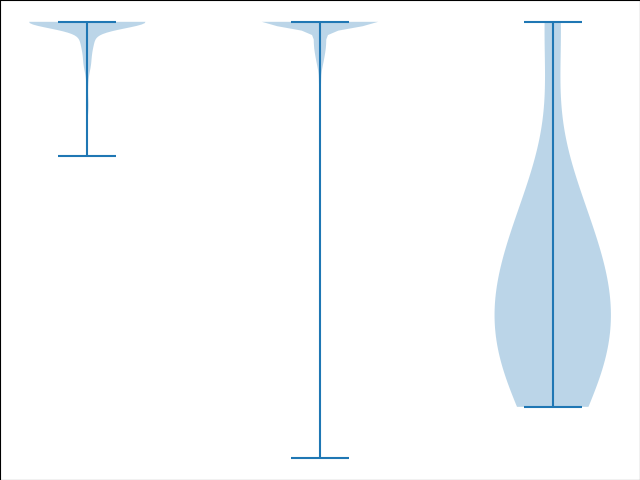

Get PSI values of all SF3B1 mutated samples, not just K700E

In [ ]:
#get list of SF3B1 (not just K700E) case IDs
mut=pd.read_csv('mut_freq.tablewPTMfixed',sep='\t',header=None) #The table has no header
mutSF3B1=mut[(mut.iloc[:,2]=='SF3B1')] #apply filter for SF3B1
#get IDs 
SF3B1ID=mutSF3B1.iloc[:,0].tolist() #this is the ssmID for SF3B1
SF3B1ID=list(set(SF3B1ID))

os.chdir('/dfs5/bio/jingtiw2/SpitaleLab/PTM/PTM_list/TCGA') #change directory
IDdf=pd.read_csv('ssm_case_id.txt', sep='\t',header=None) #read the table containing ssm ID (col0) and corresponding case IDs (col1)
#caseIDs=IDdf[IDdf.iloc[:,0]==SF3B1ID].iloc[:,1].tolist() #list of case IDs with the SF3B1 mutation

caseIDs=IDdf[IDdf.iloc[:,0].isin(SF3B1ID)].iloc[:,1]
caseIDs=list(set(caseIDs))

os.chdir('/dfs5/bio/jingtiw2/SpitaleLab/SplicingTCGA/workingfiles')
with open('SF3B1caseIDs.txt', 'w+') as f: # write caseIDs to file for use in R
     for items in caseIDs:
         f.write('%s\n' %items)
     print("File written successfully")

Converted the SF3B1 case IDs to TCGA barcodes in R

In [ ]:
IDbarcode=pd.read_csv('SF3B1barcodes.txt',sep='\t') #read table generated in R
SF3B1barcodes=IDbarcode['submitter_id'].tolist() #save barcodes as a list
listtoremove=['TCGA-AZ-4615', 'TCGA-B5-A11U', 'TCGA-B5-A11E', 'TCGA-E6-A1LX', 'TCGA-EY-A1GI', 
                     'TCGA-A5-A0GI', 'TCGA-12-0828', 'TCGA-B5-A11N', 'TCGA-FI-A2D5', 'TCGA-CN-A6V1', 
                     'TCGA-AA-A00N', 'TCGA-AA-3510', 'TCGA-BG-A222', 'TCGA-AX-A1CE', 'TCGA-AB-2828', 
                     'TCGA-A5-A0G1', 'TCGA-EE-A3AE', 'TCGA-AA-A010', 'TCGA-BS-A0UF', 'TCGA-AA-3672', 
                     'TCGA-AP-A1DK', 'TCGA-AP-A0LM', 'TCGA-AP-A0LD', 'TCGA-A5-A0G2', 'TCGA-D1-A103', 
                     'TCGA-AA-3977', 'TCGA-D1-A15X', 'TCGA-BS-A0UM', 'TCGA-AX-A06F', 'TCGA-EY-A1GD', 
                     'TCGA-BS-A0UV', 'TCGA-B5-A1MR', 'TCGA-D1-A16X', 'TCGA-AX-A05Z', 'TCGA-AX-A06L', 
                     'TCGA-AB-2912', 'TCGA-B7-5816', 'TCGA-AP-A051', 'TCGA-A5-A1OF', 'TCGA-AX-A0J1', 
                     'TCGA-CK-4951', 'TCGA-AA-3967', 'TCGA-D1-A17M', 'TCGA-AX-A2H8', 'TCGA-19-5956', 
                     'TCGA-B5-A1MX', 'TCGA-EY-A1H0', 'TCGA-AP-A1E0', 'TCGA-EO-A22R', 'TCGA-AP-A1DO', 
                     'TCGA-14-1821', 'TCGA-14-1794', 'TCGA-BG-A2AE', 'TCGA-BS-A0TC', 'TCGA-AA-3984', 
              'TCGA-AP-A1DV','TCGA-AB-2929']
SF3B1barcodes2=list(set(SF3B1barcodes)-set(listtoremove)) #removing this case from the list since it is not found in the Ratsch data
list1=['event_id','event_type','event_chr','event_coordinates','alt_region_coordinates', 'gene_name']
SF3B1barcodes3=list1+SF3B1barcodes2 #prepending gene names to the list of barcodes

import datetime as dt
start = dt.datetime.now()
print('{} seconds: Starting...'.format((dt.datetime.now() - start).seconds))
PSISF3B1 = pd.read_csv('threeprimePSItrimmedheader', usecols = SF3B1barcodes3, low_memory = True, sep='\t') #pandas read select columns.
print('{} seconds: completed'.format((dt.datetime.now() - start).seconds))

In [ ]:
#list of ORAI2 PSI values of SF3B1 mutated samples
SF3B1ORAI2PSI=PSISF3B1.loc[PSISF3B1['event_id']=='alt_3prime_227154'].iloc[:,6:].dropna(axis=1).values.flatten().tolist()

In [ ]:
#https://www.tutorialspoint.com/matplotlib/matplotlib_violin_plot.htm plotting violin plots
data_to_plot = [NormORAI2PSI, AllORAI2PSI, SF3B1ORAI2PSI, K700EORAI2PSI]
# Create a figure instance
fig = plt.figure()

# Create an axes instance
#ax = fig.add_axes([0,0,1,1])
ax = fig.gca()
xticklabels = ['Normal', 'All Cancers', 'SF3B1', 'K700E']
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(xticklabels)
ax.set_title('ORAI2')
#ax.set_xlabel('type')
ax.set_ylabel('Percent Spliced In')

# Create the boxplot
bp = ax.violinplot(data_to_plot, showmedians=True)
plt.show()